# 加载预训练模型

In [1]:
import numpy as np
import torch
from diffusers.models import AutoencoderKL
device="cuda" if torch.cuda.is_available() else "cpu"
vae = AutoencoderKL.from_pretrained("./SDXL",use_safetensors=True,local_files_only=True).to(device)
print(vae.config)

FrozenDict([('in_channels', 3), ('out_channels', 3), ('down_block_types', ['DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D', 'DownEncoderBlock2D']), ('up_block_types', ['UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D', 'UpDecoderBlock2D']), ('block_out_channels', [128, 256, 512, 512]), ('layers_per_block', 2), ('act_fn', 'silu'), ('latent_channels', 4), ('norm_num_groups', 32), ('sample_size', 512), ('scaling_factor', 0.18215), ('latents_mean', None), ('latents_std', None), ('force_upcast', True), ('_use_default_values', ['scaling_factor', 'latents_mean', 'force_upcast', 'latents_std']), ('_class_name', 'AutoencoderKL'), ('_diffusers_version', '0.6.0'), ('_name_or_path', './SDXL')])


# 加载输入视频

In [2]:
import cv2
from PIL import Image
frame_num=125
video_path="assets/example1.mp4"
video = cv2.VideoCapture(video_path)
frames = []
for i in range(frame_num):
    ret, frame = video.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame_PIL = Image.fromarray(frame).resize((512, 512))
    frames.append(frame_PIL)


# 预处理

In [3]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor
def preprocess(image, image_size=512):
    transform = Compose([
        Resize(image_size),
        CenterCrop(image_size),
        ToTensor(),
    ])
    return transform(image).unsqueeze(0)
image_size=512
input_tensor = torch.cat([preprocess(image, image_size) for image in frames]).to(device)
print(input_tensor.shape)

torch.Size([125, 3, 512, 512])


# VAE测试

In [4]:
from tqdm import tqdm
output_tensor=None
batch_size=2
for i in tqdm(range(0, input_tensor.shape[0], batch_size)):
    batch_input_tensor = input_tensor[i:i + batch_size].to(device)
    with torch.no_grad():
        # 编码
        latents = vae.encode(batch_input_tensor).latent_dist.sample()

        # 打印潜在向量的形状
        #print("Latents shape:", latents.shape)

        # 解码
        batch_output_tensor = vae.decode(latents).sample

        output_tensor = batch_output_tensor if output_tensor is None else torch.cat([output_tensor, batch_output_tensor])
        # 打印输出张量的形状
        # print("Output shape:", output_tensor.shape)
        # print(output_tensor.min(), output_tensor.max())

# 2. 计算L1 Loss
l1_loss = torch.nn.functional.l1_loss(input_tensor, output_tensor)

print(f"L1 Loss: {l1_loss.item()}")
clamped_output_tensor = output_tensor.clamp(0, 1)
output_images = [(image_tensor.squeeze(0) * 255).permute(1, 2, 0).byte().cpu().numpy() for image_tensor in
                 clamped_output_tensor]
output_images = [Image.fromarray(output_image) for output_image in output_images]

100%|██████████| 63/63 [00:22<00:00,  2.83it/s]


L1 Loss: 0.02139960415661335


# 保存视频

In [5]:
out_path="results/concat_example1.mp4"
height=max(frames[0].height,output_images[0].height)
width=3*frames[0].width
out = cv2.VideoWriter(out_path, cv2.VideoWriter_fourcc(*'mp4v'), 25, (width, height))
for i in range(len(frames)):
    img1 = cv2.cvtColor(np.array(frames[i]), cv2.COLOR_RGB2BGR)
    img2 = cv2.cvtColor(np.array(output_images[i]), cv2.COLOR_RGB2BGR)
    diff_image = np.abs(img1 - img2)
    img = cv2.hconcat([img1, img2,diff_image])
    out.write(img)
print("saved video")
out.release()

saved video


# 随机挑选展示

[ 65  29 120  79  55  22  83  46 103  43]


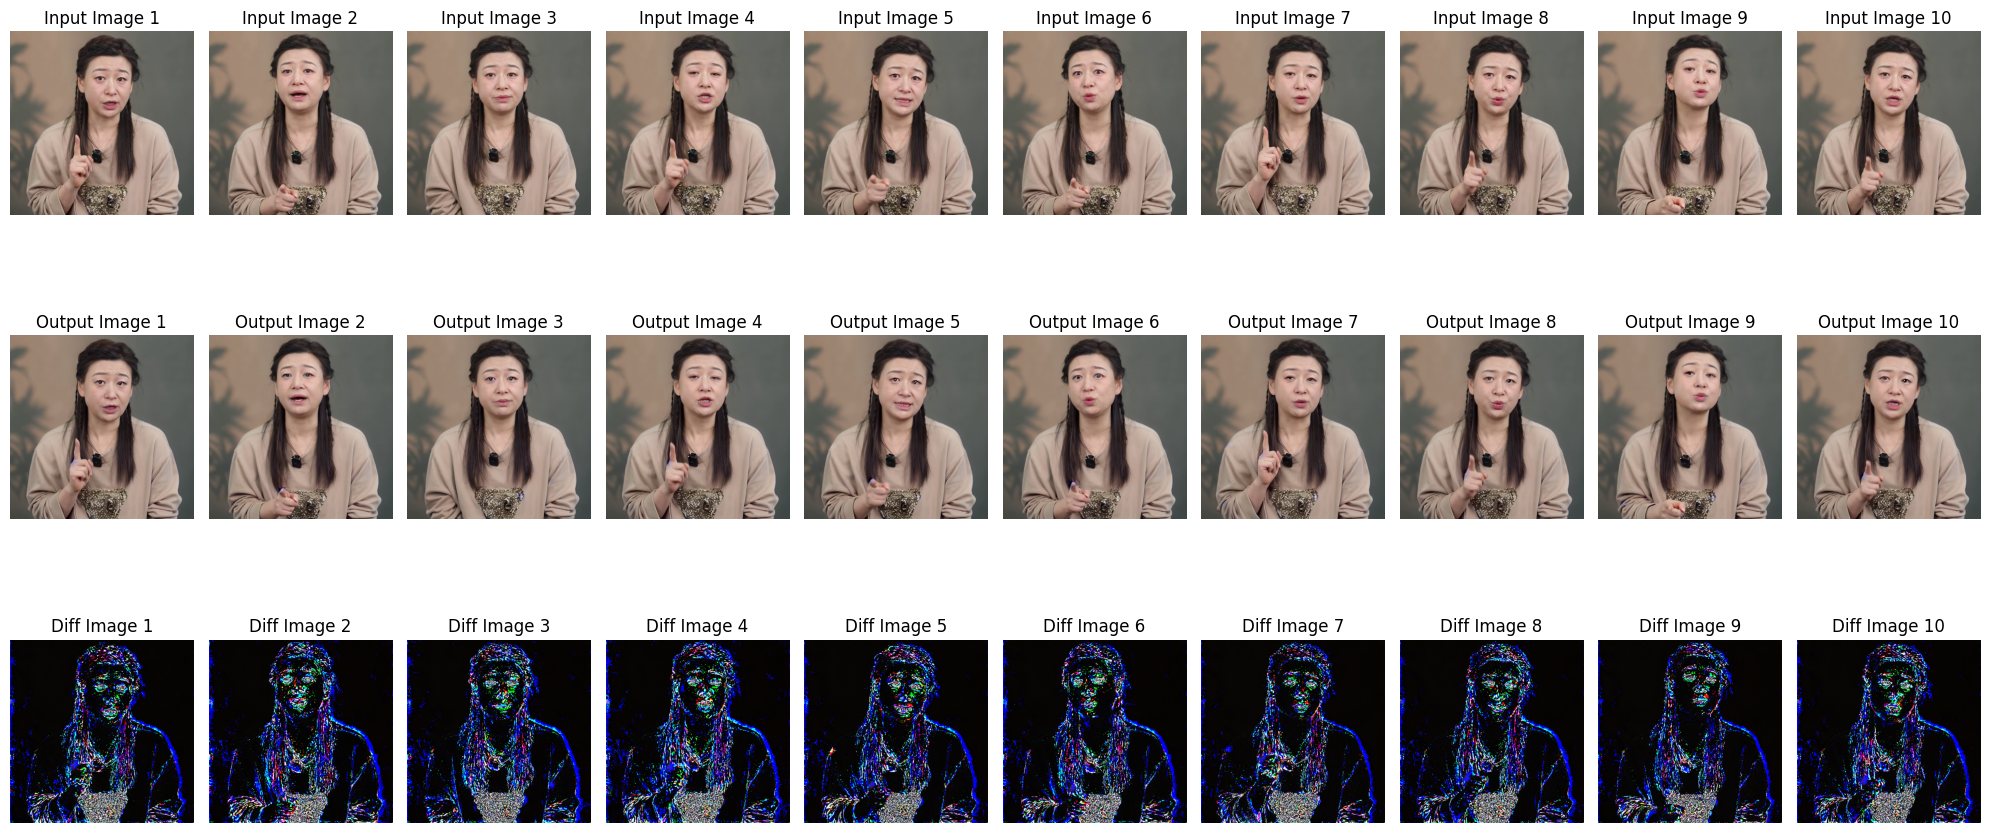

In [6]:
import matplotlib.pyplot as plt
random_num =10
random_id = np.random.choice(frame_num, random_num, replace=False)
print(random_id)
random_frames=[ (frames[index]) for index in random_id]
output_images=[ (output_images[index]) for index in random_id]
image_size=512
# 计算需要的列数（每组图片需要3列）
num_columns = len(random_frames)

# 计算需要的行数，这里每个图片对都会占用一行
num_rows = 3

# 创建一个大的画布
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 10))
for i in range(len(random_frames)):
    # 将当前的 input 和 output 图片缩放到 image_size
    input_image_resized = random_frames[i].resize((image_size, image_size))
    output_image_resized = output_images[i].resize((image_size, image_size))

    # 将 PIL 图片对象转换为 NumPy 数组
    input_image_array = np.asarray(input_image_resized)
    output_image_array = np.asarray(output_image_resized)

    # 计算差异图片
    diff_image_array = np.abs(input_image_array - output_image_array)

    # 显示输入图片
    axes[0, i].imshow(input_image_array)
    axes[0, i].set_title(f"Input Image {i + 1}")
    axes[0, i].axis("off")

    # 显示输出图片
    axes[1, i].imshow(output_image_array)
    axes[1, i].set_title(f"Output Image {i + 1}")
    axes[1, i].axis("off")

    # 显示差异图片
    axes[2, i].imshow(diff_image_array)
    axes[2, i].set_title(f"Diff Image {i + 1}")
    axes[2, i].axis("off")

# 调整布局
plt.tight_layout()
plt.show()